<a href="https://colab.research.google.com/github/majd2003omari/loan_stuat_project/blob/main/DEEPL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting and install

In [ ]:
pip install --upgrade scikeras tensorflow scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but y

In [ ]:
!pip install scikeras

# load_data and split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ملفات الكولاب /train_balanced.csv")
df_test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ملفات الكولاب /test_original.csv")

X_train = df.drop("loan_status", axis=1)
y_train = df["loan_status"]
X_test=df_test.drop("loan_status", axis=1)
y_test= df_test["loan_status"]
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
list_model=[]

# Function EVALUATION

In [ ]:


import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def get_model_scores_full(model, model_name):
    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_prob)

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Specificity": specificity,
        "ROC_AUC": roc_auc
    }




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

def plot_model_evaluation(model, history=None, model_name="Model"):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)


    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0,0])
    axs[0,0].set_title(f"{model_name} Confusion Matrix")
    axs[0,0].set_xlabel("Predicted")
    axs[0,0].set_ylabel("Actual")


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axs[0,1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    axs[0,1].plot([0,1], [0,1], '--', color="gray")
    axs[0,1].set_title(f"{model_name} ROC Curve")
    axs[0,1].set_xlabel("False Positive Rate")
    axs[0,1].set_ylabel("True Positive Rate")
    axs[0,1].legend()
    axs[0,1].grid(True)


    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    axs[1,0].plot(prob_pred, prob_true, marker="o")
    axs[1,0].plot([0,1], [0,1], "--", color="gray")
    axs[1,0].set_title(f"{model_name} Calibration Curve")
    axs[1,0].set_xlabel("Predicted Probability")
    axs[1,0].set_ylabel("True Probability")
    axs[1,0].grid(True)


    if history is not None:
        axs[1,1].plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            axs[1,1].plot(history.history['val_loss'], label='Validation Loss')
        axs[1,1].set_title(f"{model_name} Loss Curve")
        axs[1,1].set_xlabel("Epoch")
        axs[1,1].set_ylabel("Loss")
        axs[1,1].legend()
        axs[1,1].grid(True)
    else:
        axs[1,1].axis('off')

    plt.tight_layout()
    plt.show()

# model and regulization

In [ ]:
model_original=Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
model_original.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_original.summary()
history_original= model_original.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        epochs=25,
        batch_size=16,
        verbose=1
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,081 (117.50 KB)

 Trainable params: 30,081 (117.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8793 - loss: 0.2706 - val_accuracy: 0.8917 - val_loss: 0.2233
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8956 - loss: 0.2233 - val_accuracy: 0.8966 - val_loss: 0.2126
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8931 - loss: 0.2197 - val_accuracy: 0.8948 - val_loss: 0.2155
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8992 - loss: 0.2109 - val_accuracy: 0.9011 - val_loss: 0.2071
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8993 - loss: 0.2108 - val_accuracy: 0.8952 - val_loss: 0.2107
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8997 - loss: 0.2078 - val_accuracy: 0.8990 - val_loss: 0.2035
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9028 - loss: 0.2015 - val_accuracy: 0.9004 - val_loss: 0.2054
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9011 - loss: 0.1997 -

In [ ]:
model_Droup=Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
model_Droup.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_Droup.summary()
history_Droup= model_Droup.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        epochs=25,
        batch_size=16,
        verbose=1
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,081 (117.50 KB)

 Trainable params: 30,081 (117.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8645 - loss: 0.2979 - val_accuracy: 0.8950 - val_loss: 0.2275
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8900 - loss: 0.2379 - val_accuracy: 0.8948 - val_loss: 0.2173
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8922 - loss: 0.2306 - val_accuracy: 0.8966 - val_loss: 0.2141
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8920 - loss: 0.2258 - val_accuracy: 0.8970 - val_loss: 0.2158
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8942 - loss: 0.2221 - val_accuracy: 0.8963 - val_loss: 0.2125
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8960 - loss: 0.2195 - val_accuracy: 0.8957 - val_loss: 0.2123
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8950 - loss: 0.2182 - val_accuracy: 0.8990 - val_loss: 0.2097
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8953 - loss: 0.2183

In [ ]:
model_batch=Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
model_batch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_batch.summary()
history_batch= model_batch.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        epochs=25,
        batch_size=16,
        verbose=1
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_402 (Dense)               │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_201         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_202         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,913 (120.75 KB)

 Trainable params: 30,497 (119.13 KB)

 Non-trainable params: 416 (1.62 KB)

Epoch 1/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8594 - loss: 0.3104 - val_accuracy: 0.8937 - val_loss: 0.2294
Epoch 2/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8846 - loss: 0.2514 - val_accuracy: 0.8998 - val_loss: 0.2159
Epoch 3/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8868 - loss: 0.2450 - val_accuracy: 0.8979 - val_loss: 0.2148
Epoch 4/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8892 - loss: 0.2383 - val_accuracy: 0.8979 - val_loss: 0.2159
Epoch 5/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8944 - loss: 0.2319 - val_accuracy: 0.8993 - val_loss: 0.2080
Epoch 6/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8929 - loss: 0.2331 - val_accuracy: 0.8954 - val_loss: 0.2167
Epoch 7/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8928 - loss: 0.2278 - val_accuracy: 0.9007 - val_loss: 0.2096
Epoch 8/25
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8947 - loss: 0

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_mix=Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.25),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])

scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
model_mix.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_mix= model_mix.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    verbose=1,
    callbacks=[scheduler]
)










Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8302 - loss: 0.3680 - val_accuracy: 0.8913 - val_loss: 0.2320 - learning_rate: 0.0010
Epoch 2/25
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8763 - loss: 0.2683 - val_accuracy: 0.8914 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 3/25
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8846 - loss: 0.2569 - val_accuracy: 0.8968 - val_loss: 0.2202 - learning_rate: 0.0010
Epoch 4/25
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8857 - loss: 0.2515 - val_accuracy: 0.8942 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 5/25
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8850 - loss: 0.2465 - val_accuracy: 0.8986 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 6/25
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8864 - loss: 0.2448 - val_accuracy: 0.8971 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 7/25
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8854 - loss: 0.242

## Comparing the techniques and adding to the results

In [ ]:
results_all = {
    "Original": get_model_scores_full(model_original, "Original"),
    "Dropout": get_model_scores_full(model_Droup, "Dropout"),
    "BatchNorm": get_model_scores_full(model_batch, "BatchNorm"),
    "Mixed": get_model_scores_full(model_mix, "Mixed")
}

df_results = pd.DataFrame.from_dict(results_all, orient='index')
print(df_results)

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
           Accuracy  Precision  Recall        F1  Specificity   ROC_AUC
Original   0.885556   0.687693  0.8885  0.775305     0.884714  0.966361
Dropout    0.885444   0.683871  0.9010  0.777562     0.881000  0.967804
BatchNorm  0.898333   0.725759  0.8720  0.792187     0.905857  0.965865
Mixed      0.873889   0.654189  0.9175  0.763788     0.861429  0.968332


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


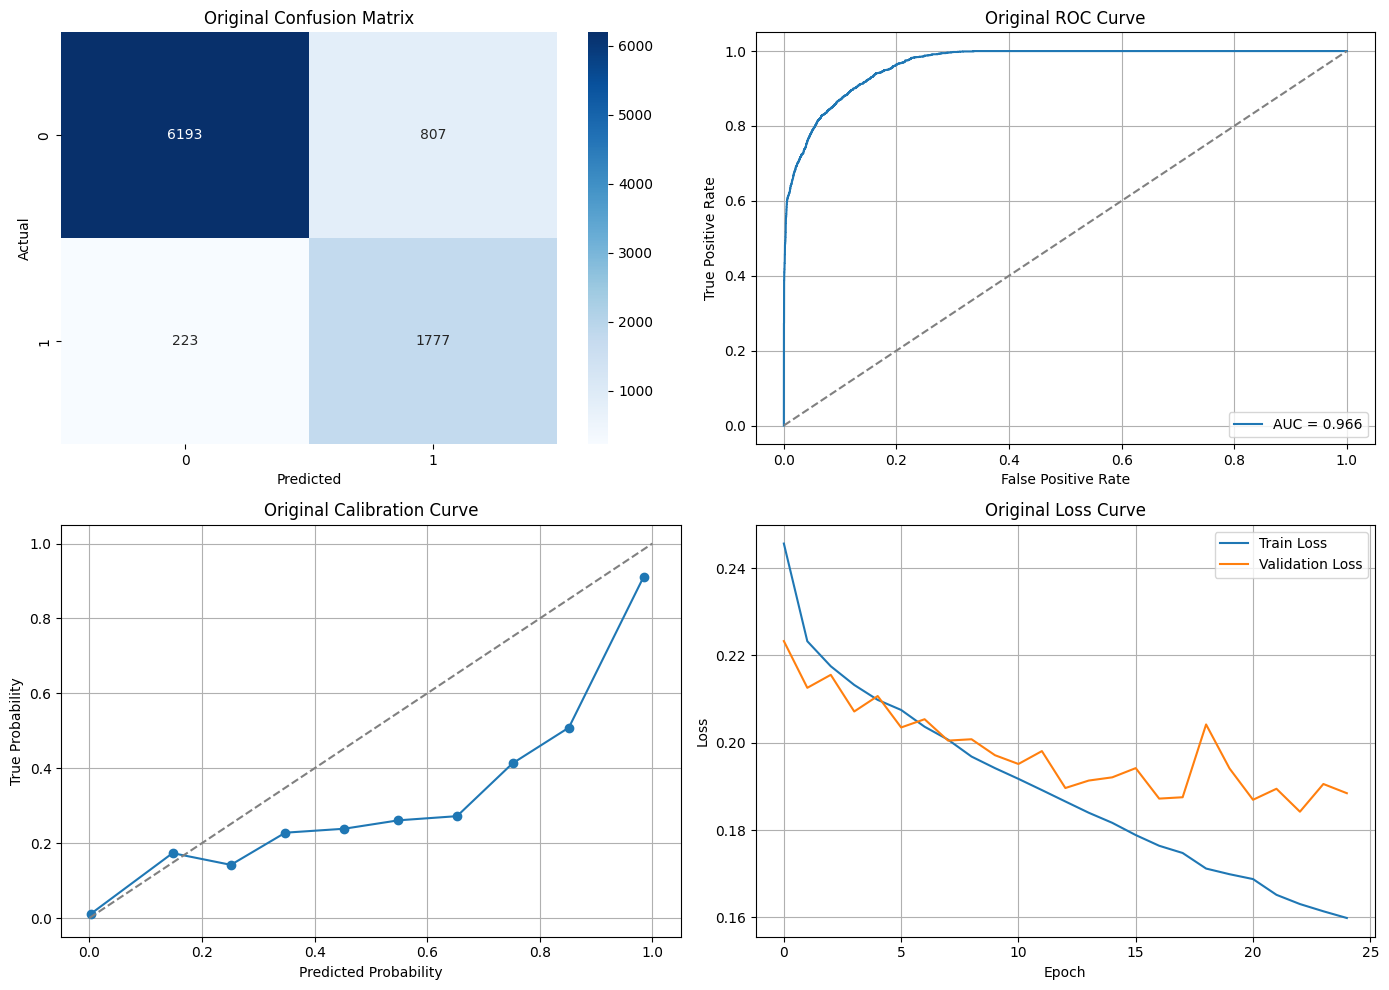

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


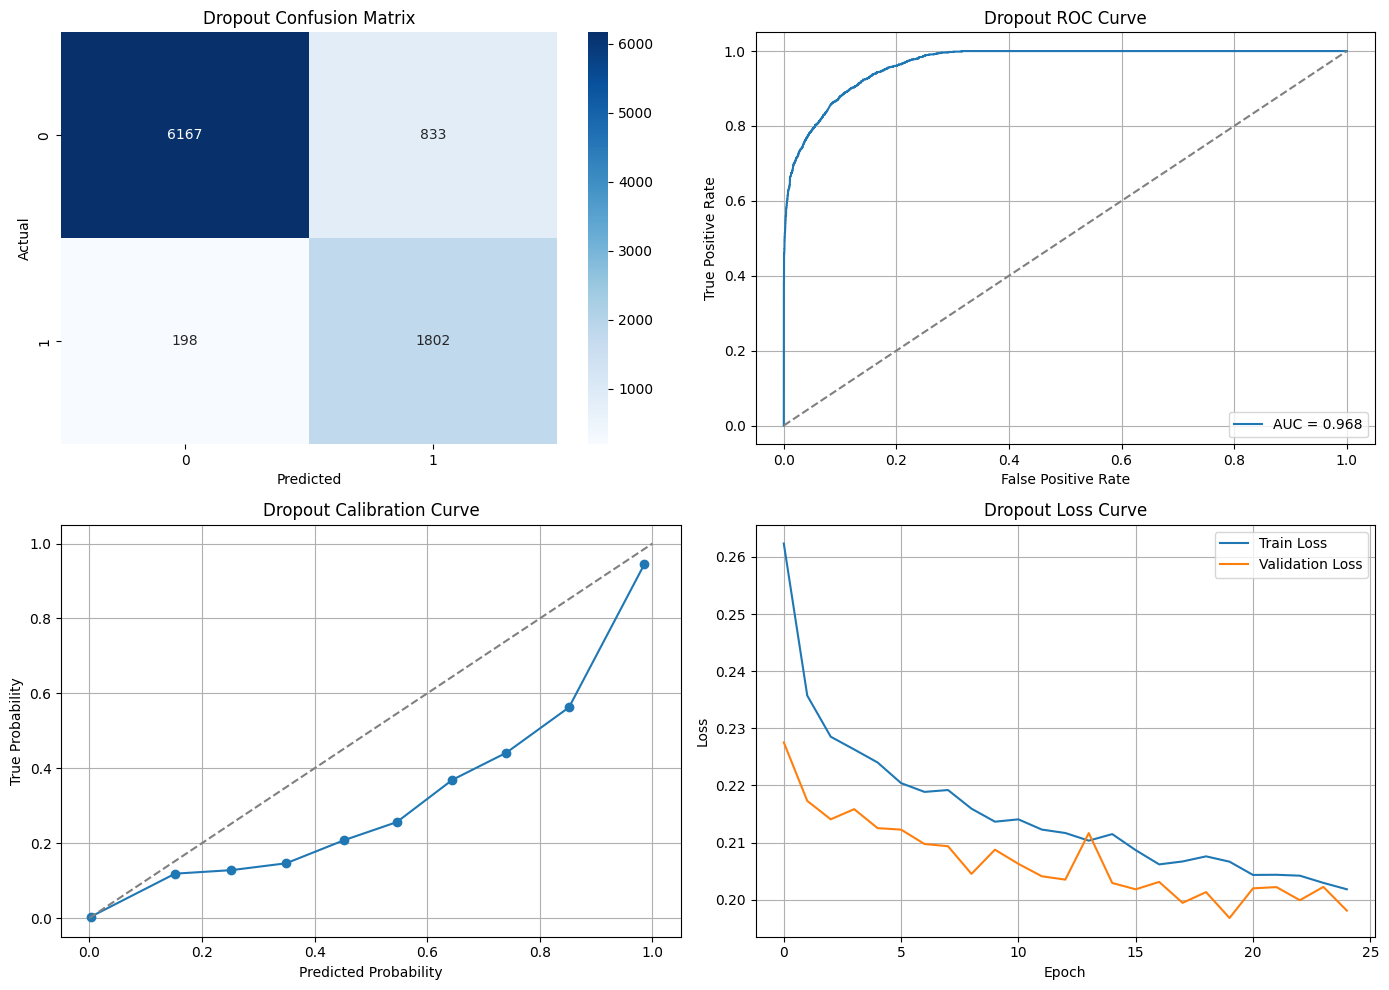

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


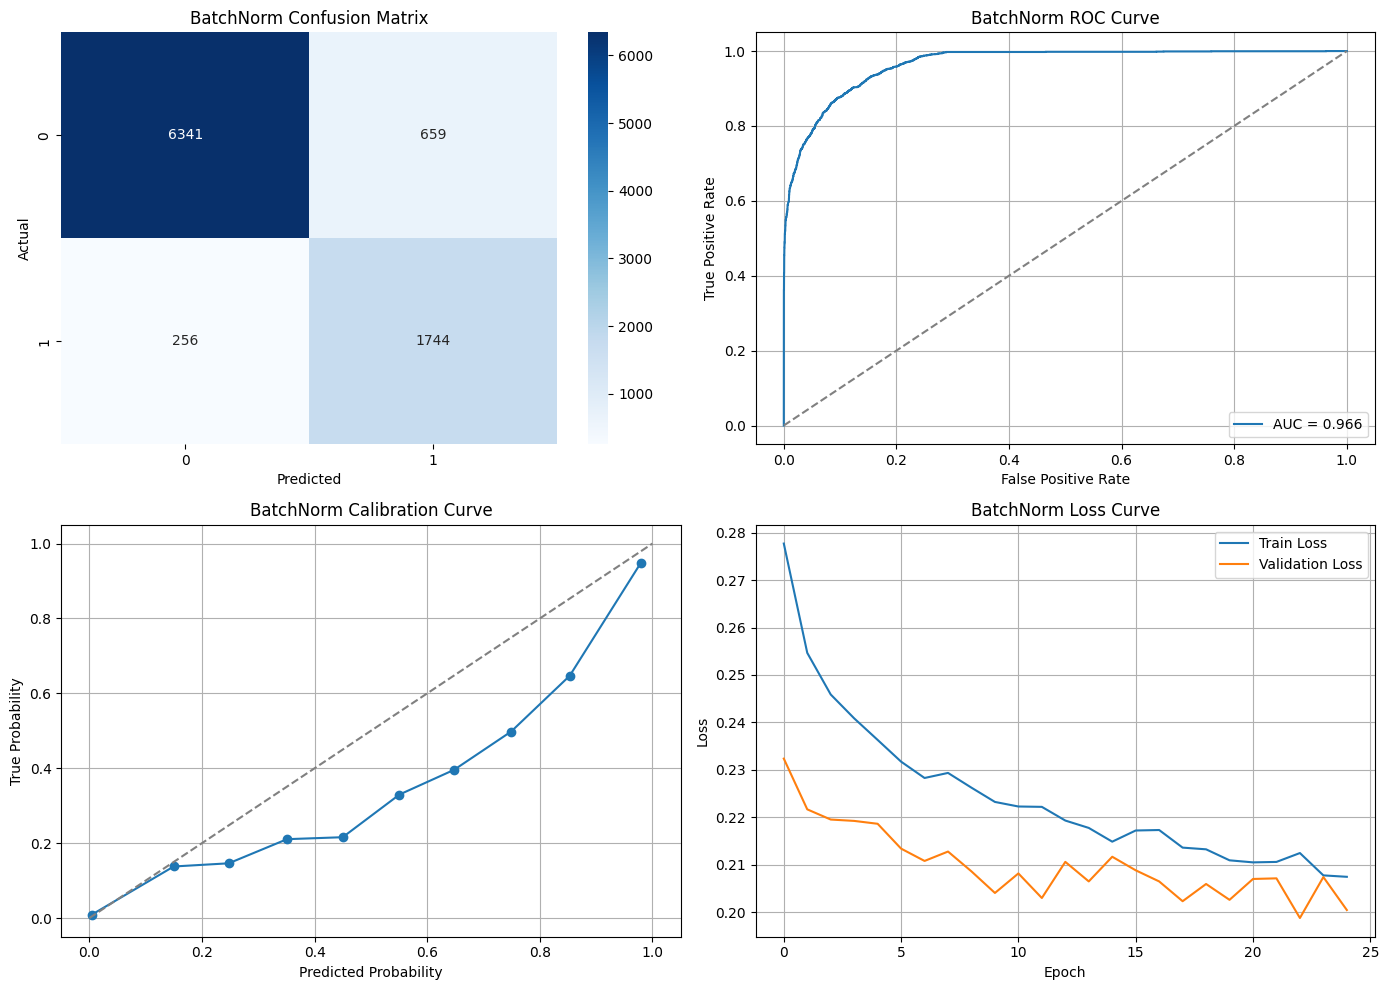

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


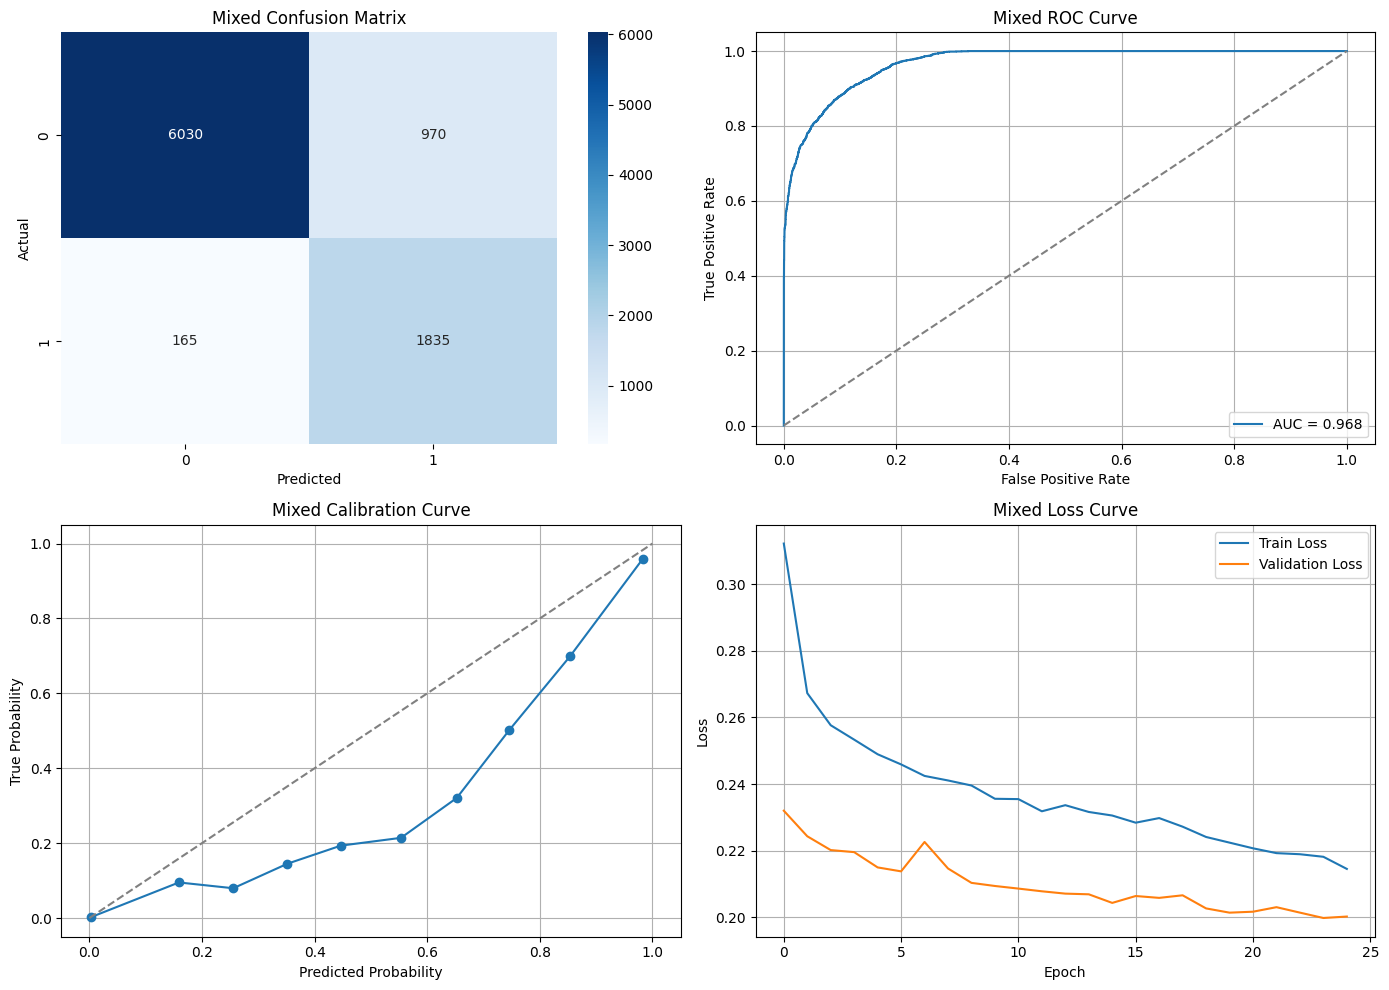

In [ ]:
plot_model_evaluation(model_original,history_original,"Original")
plot_model_evaluation(model_Droup,history_Droup ,"Dropout")
plot_model_evaluation(model_batch,history_batch, "BatchNorm")
plot_model_evaluation(model_mix,history_mix ,"Mixed")



## Model Development Steps

## Model Variants
We tested four models:
1. **Original Model**: Without any regularization.  
2. **Dropout Model**: Introduced Dropout regularization.  
3. **Batch Normalization Model**: Used Batch Normalization.  
4. **Mixed Model**: Combined Dropout, Batch Normalization, and ReduceLROnPlateau scheduler.

## Scheduler Integration
The mixed model utilized the ReduceLROnPlateau scheduler to dynamically adjust the learning rate based on the validation loss.


## Model Selection
- **Original Model**: While the original model showed some overfitting, it still performed comparably well.  
- **Dropout Model**: Although it reduced overfitting slightly, it still exhibited significant fluctuations, and the validation loss sometimes exceeded the training loss, indicating instability.  
- **Batch Normalization Model**: This model effectively reduced overfitting. Even though there were some fluctuations, the validation loss remained stable and did not exceed the training loss, indicating balanced training.  
- **Mixed Model**: The combination of Dropout, Batch Normalization, and the scheduler led to slower learning and less effective training, with a significant gap between training and validation loss.

## Results Table

| Model Type | Accuracy | Precision | Recall | F1 Score | Specificity | ROC AUC |
|-----------|----------|----------|--------|---------|------------|---------|
| Original | 0.8856 | 0.6877 | 0.8885 | 0.7753 | 0.8847 | 0.9664 |
| Dropout | 0.8854 | 0.6839 | 0.9010 | 0.7776 | 0.8810 | 0.9678 |
| Batch Normalization | 0.8983 | 0.7258 | 0.8720 | 0.7922 | 0.9059 | 0.9659 |
| Mixed | 0.8739 | 0.6542 | 0.9175 | 0.7638 | 0.8614 | 0.9683 |

## Interpretation
In general, **Batch Normalization** proved to be the best choice for reducing overfitting, maintaining stability, and keeping the validation loss under control.  
The original model showed some overfitting, while the mixed model struggled with slower learning and less effective training.  
We decided to proceed with **Batch Normalization** for further tuning and hyperparameter optimization using Grid Search and Cross-Validation.


# CROSS VALIDATION without GRIDE SEARCH

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8991 - loss: 0.2171 - val_accuracy: 0.9158 - val_loss: 0.1861
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9002 - loss: 0.2162 - val_accuracy: 0.9135 - val_loss: 0.1885
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8997 - loss: 0.2167 - val_accuracy: 0.9134 - val_loss: 0.1912
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9027 - loss: 0.2101 - val_accuracy: 0.9087 - val_loss: 0.1916
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9037 - loss: 0.2074 - val_accuracy: 0.9119 - val_loss: 0.1935
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9031 - loss: 0.2111 - val_accuracy: 0.9112 - val_loss: 0.1878
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9027 - loss: 0.2127 - val_accuracy: 0.9114 - val_loss: 0.1898
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9018 - loss: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9080 - loss: 0.1983 - val_accuracy: 0.9176 - val_loss: 0.1775
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9063 - loss: 0.1975 - val_accuracy: 0.9198 - val_loss: 0.1758
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9061 - loss: 0.2012 - val_accuracy: 0.9172 - val_loss: 0.1794
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9083 - loss: 0.1970 - val_accuracy: 0.9163 - val_loss: 0.1800
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9081 - loss: 0.1987 - val_accuracy: 0.9139 - val_loss: 0.1811
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9091 - loss: 0.1944 - val_accuracy: 0.9186 - val_loss: 0.1776
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9115 - loss: 0.1919 - val_accuracy: 0.9179 - val_loss: 0.1783
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9110 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9119 - loss: 0.1921 - val_accuracy: 0.9224 - val_loss: 0.1715
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9112 - loss: 0.1925 - val_accuracy: 0.9247 - val_loss: 0.1714
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9136 - loss: 0.1890 - val_accuracy: 0.9246 - val_loss: 0.1731
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9132 - loss: 0.1867 - val_accuracy: 0.9241 - val_loss: 0.1744
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9132 - loss: 0.1907 - val_accuracy: 0.9219 - val_loss: 0.1757
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9150 - loss: 0.1870 - val_accuracy: 0.9252 - val_loss: 0.1727
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9143 - loss: 0.1839 - val_accuracy: 0.9223 - val_loss: 0.1761
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9142 - loss: 0.1873 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9135 - loss: 0.1867 - val_accuracy: 0.9261 - val_loss: 0.1634
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9163 - loss: 0.1841 - val_accuracy: 0.9253 - val_loss: 0.1647
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9158 - loss: 0.1855 - val_accuracy: 0.9243 - val_loss: 0.1658
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9166 - loss: 0.1824 - val_accuracy: 0.9234 - val_loss: 0.1669
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9190 - loss: 0.1789 - val_accuracy: 0.9202 - val_loss: 0.1746
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9174 - loss: 0.1818 - val_accuracy: 0.9233 - val_loss: 0.1676
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9188 - loss: 0.1795 - val_accuracy: 0.9224 - val_loss: 0.1717
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9165 - loss: 0.1843 - val_a

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9172 - loss: 0.1802 - val_accuracy: 0.9315 - val_loss: 0.1540
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9220 - loss: 0.1753 - val_accuracy: 0.9284 - val_loss: 0.1573
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9214 - loss: 0.1725 - val_accuracy: 0.9284 - val_loss: 0.1567
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9190 - loss: 0.1772 - val_accuracy: 0.9277 - val_loss: 0.1571
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9182 - loss: 0.1794 - val_accuracy: 0.9292 - val_loss: 0.1584
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9199 - loss: 0.1780 - val_accuracy: 0.9268 - val_loss: 0.1649
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9193 - loss: 0.1791 - val_accuracy: 0.9261 - val_loss: 0.1651
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9208 - loss: 0.1767 - val_

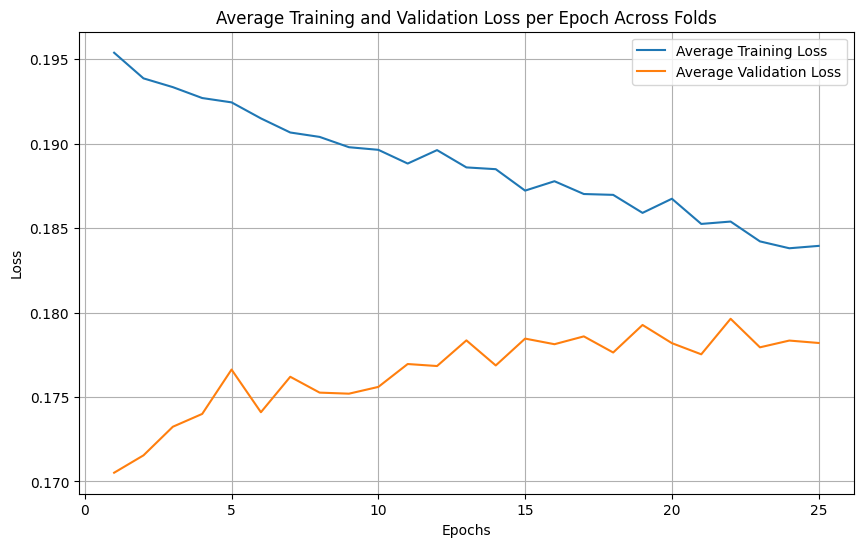

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Metric,Mean Value
0,Accuracy,0.933143
1,Precision,0.905265
2,Recall,0.967536
3,F1-score,0.935365
4,Specificity,0.898750
5,ROC-AUC,0.985393


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


X_train = df.drop("loan_status", axis=1)
y_train = df["loan_status"]


def create_batchnorm_model():
    model1= Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


histories_1= []
models_info_1 = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model1 = create_batchnorm_model()
    history1 = model1.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=25,
        batch_size=16,
        verbose=1
    )

    histories_1.append(history1)
    models_info_1.append((model1, X_fold_val, y_fold_val))


num_epochs = 25
avg_train_loss = np.zeros(num_epochs)
avg_val_loss = np.zeros(num_epochs)

for history in histories_1:
    avg_train_loss += np.array(history.history['loss'])
    avg_val_loss += np.array(history.history['val_loss'])

avg_train_loss /= len(histories_1)
avg_val_loss /= len(histories_1)


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), avg_train_loss, label='Average Training Loss')
plt.plot(range(1, num_epochs+1), avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss per Epoch Across Folds')
plt.legend()
plt.grid(True)
plt.show()


val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_specificity = []
val_roc_auc = []

for model, X_val, y_val in models_info_1:
    y_pred_prob = model.predict(X_val).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    val_accuracy.append(accuracy_score(y_val, y_pred))
    val_precision.append(precision_score(y_val, y_pred))
    val_recall.append(recall_score(y_val, y_pred))
    val_f1.append(f1_score(y_val, y_pred))
    val_roc_auc.append(roc_auc_score(y_val, y_pred_prob))

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)
    val_specificity.append(specificity)


validation_results_df_wout = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity', 'ROC-AUC'],
    'Mean Value': [
        np.mean(val_accuracy),
        np.mean(val_precision),
        np.mean(val_recall),
        np.mean(val_f1),
        np.mean(val_specificity),
        np.mean(val_roc_auc)
    ]
})


validation_results_df_wout


# CROSS VALIDATION +GRIDE SEARCH

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


X_train = df.drop("loan_status", axis=1)
y_train = df["loan_status"]

def create_model(n_neurons1=256, n_neurons2=128, learning_rate=0.001):
    model = Sequential([
        Dense(n_neurons1, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dense(n_neurons2, activation='relu'),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


keras_clf = KerasClassifier(model=create_model, epochs=15, batch_size=16, verbose=0)


param_grid = {
    'model__n_neurons1': [256, 128],
    'model__n_neurons2': [128, 64],
    'model__learning_rate': [0.001, 0.0005, 0.00005]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(estimator=keras_clf, param_grid=param_grid, scoring=f1_scorer, cv=cv, verbose=1)
grid_result = grid.fit(X_train, y_train)


print("Best Parameters Found:", grid_result.best_params_)







Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best Parameters Found: {'model__learning_rate': 5e-05, 'model__n_neurons1': 256, 'model__n_neurons2': 128}


KeyError: 'model'

In [ ]:

best_params = {k.replace('model__',''): v for k, v in grid_result.best_params_.items()}

print("Best Parameters Found:", best_params)

print("Best F1 Score:", grid_result.best_score_)


Best Parameters Found: {'learning_rate': 5e-05, 'n_neurons1': 256, 'n_neurons2': 128}
Best F1 Score: 0.904152934954611


## Result_ grid_search_ :
Best F1 Score: 0.904152934954611


Best Parameters Found: {'model__learning_rate': 5e-05, 'model__n_neurons1': 256, 'model__n_neurons2': 128}

## Neural Network Training and Validation Using Stratified K-Fold Cross-Validation on epochs=25

In [ ]:
histories = []
models = []

for train_index, val_index in cv.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    model = create_model(**best_params)
    history = model.fit(
        X_fold_train, y_fold_train,
        epochs=25,
        batch_size=16,
        verbose=1,
        validation_data=(X_fold_val, y_fold_val)
    )

    histories.append(history)
    models.append((model, X_fold_val, y_fold_val))



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.7967 - loss: 0.4355 - val_accuracy: 0.8888 - val_loss: 0.2391
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8761 - loss: 0.2761 - val_accuracy: 0.8939 - val_loss: 0.2244
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8836 - loss: 0.2606 - val_accuracy: 0.8947 - val_loss: 0.2198
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8819 - loss: 0.2607 - val_accuracy: 0.8976 - val_loss: 0.2144
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8885 - loss: 0.2500 - val_accuracy: 0.8995 - val_loss: 0.2123
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8889 - loss: 0.2467 - val_accuracy: 0.8993 - val_loss: 0.2127
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8879 - loss: 0.2459 - val_accuracy: 0.8997 - val_loss: 0.2124
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8889 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8123 - loss: 0.4115 - val_accuracy: 0.8836 - val_loss: 0.2461
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8745 - loss: 0.2809 - val_accuracy: 0.8890 - val_loss: 0.2292
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8816 - loss: 0.2695 - val_accuracy: 0.8893 - val_loss: 0.2300
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8871 - loss: 0.2522 - val_accuracy: 0.8918 - val_loss: 0.2216
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8864 - loss: 0.2513 - val_accuracy: 0.8944 - val_loss: 0.2198
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8856 - loss: 0.2495 - val_accuracy: 0.8982 - val_loss: 0.2164
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8903 - loss: 0.2438 - val_accuracy: 0.8952 - val_loss: 0.2154
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8907 - loss: 0.2403 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7741 - loss: 0.4689 - val_accuracy: 0.8845 - val_loss: 0.2585
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8740 - loss: 0.2893 - val_accuracy: 0.8861 - val_loss: 0.2431
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8772 - loss: 0.2765 - val_accuracy: 0.8918 - val_loss: 0.2326
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8791 - loss: 0.2644 - val_accuracy: 0.8920 - val_loss: 0.2286
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8824 - loss: 0.2589 - val_accuracy: 0.8943 - val_loss: 0.2262
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8867 - loss: 0.2572 - val_accuracy: 0.8950 - val_loss: 0.2206
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8911 - loss: 0.2485 - val_accuracy: 0.8961 - val_loss: 0.2186
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8897 - loss: 0.2425 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7949 - loss: 0.4376 - val_accuracy: 0.8838 - val_loss: 0.2557
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8738 - loss: 0.2835 - val_accuracy: 0.8911 - val_loss: 0.2333
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8801 - loss: 0.2675 - val_accuracy: 0.8950 - val_loss: 0.2250
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8834 - loss: 0.2598 - val_accuracy: 0.8942 - val_loss: 0.2217
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8882 - loss: 0.2488 - val_accuracy: 0.8988 - val_loss: 0.2166
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8901 - loss: 0.2461 - val_accuracy: 0.8991 - val_loss: 0.2138
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8909 - loss: 0.2421 - val_accuracy: 0.8970 - val_loss: 0.2153
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8905 - loss: 0.2395 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7871 - loss: 0.4450 - val_accuracy: 0.8888 - val_loss: 0.2451
Epoch 2/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8784 - loss: 0.2740 - val_accuracy: 0.8923 - val_loss: 0.2291
Epoch 3/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8815 - loss: 0.2646 - val_accuracy: 0.8931 - val_loss: 0.2229
Epoch 4/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8871 - loss: 0.2557 - val_accuracy: 0.8959 - val_loss: 0.2186
Epoch 5/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8907 - loss: 0.2472 - val_accuracy: 0.8956 - val_loss: 0.2152
Epoch 6/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8923 - loss: 0.2417 - val_accuracy: 0.8978 - val_loss: 0.2146
Epoch 7/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8915 - loss: 0.2377 - val_accuracy: 0.8973 - val_loss: 0.2156
Epoch 8/25
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8907 - loss: 0.2385 - val

The model was trained using stratified k-fold cross-validation. For each fold, a new model was initialized using the optimal hyperparameters obtained from GridSearch, and both training history and validation predictions were stored for further performance evaluation.

## Average Training and Validation Loss Across Cross-Validation Folds

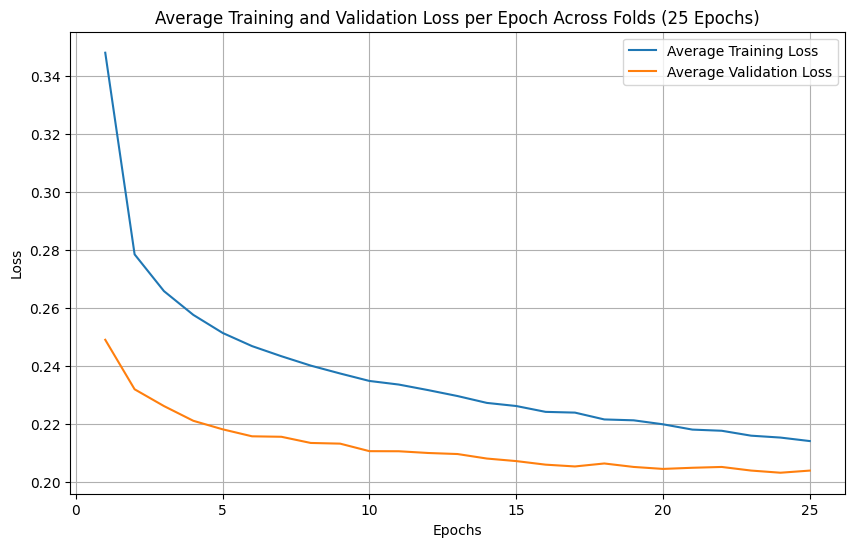

In [ ]:

num_epochs = 25
average_train_loss = np.zeros(num_epochs)
average_val_loss = np.zeros(num_epochs)

for history in histories:
    average_train_loss += np.array(history.history['loss'])
    average_val_loss += np.array(history.history['val_loss'])

average_train_loss /= len(histories)
average_val_loss /= len(histories)

# --- رسم المنحنيات ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), average_train_loss, label='Average Training Loss')
plt.plot(range(1, num_epochs+1), average_val_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss per Epoch Across Folds (25 Epochs)')
plt.legend()
plt.grid(True)
plt.show()



This figure shows the average training and validation loss per epoch across all folds using Stratified K-Fold Cross-Validation with 25 epochs.

The training loss and validation loss curves are closely aligned throughout all epochs.

There is no significant fluctuation or overfitting observed.

This indicates that the model learned the data effectively and generalized well to unseen samples.

The stable curves confirm that the chosen network architecture and hyperparameters are well-suited for the dataset, and no additional regularization is necessar

## Validation Metrics Across Cross-Validation Folds

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_specificity = []
val_roc_auc = []

for model, X_val, y_val in models:
    y_pred_prob = model.predict(X_val).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    val_accuracy.append(accuracy_score(y_val, y_pred))
    val_precision.append(precision_score(y_val, y_pred))
    val_recall.append(recall_score(y_val, y_pred))
    val_f1.append(f1_score(y_val, y_pred))
    val_roc_auc.append(roc_auc_score(y_val, y_pred_prob))

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)
    val_specificity.append(specificity)



validation_results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Specificity', 'ROC-AUC'],
    'Mean Value': [
        np.mean(val_accuracy),
        np.mean(val_precision),
        np.mean(val_recall),
        np.mean(val_f1),
        np.mean(val_specificity),
        np.mean(val_roc_auc)
    ]
})

validation_results_df





350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Metric,Mean Value
0,Accuracy,0.902607
1,Precision,0.881389
2,Recall,0.930607
3,F1-score,0.905246
4,Specificity,0.874607
5,ROC-AUC,0.972490


The table summarizes the mean performance metrics of the model on the validation sets across all folds:

Accuracy: Overall correctness of the model (≈ 90.26%).

Precision: Correct positive predictions relative to all predicted positives (≈ 88.14%).

Recall: Correct positive predictions relative to all actual positives (≈ 93.06%).

F1-score: Harmonic mean of Precision and Recall, representing balanced performance (≈ 90.52%).

Specificity: Correct negative predictions relative to all actual negatives (≈ 87.46%).

ROC-AUC: Ability of the model to discriminate between classes (≈ 97.25%).

These results confirm that the model performs well on both positive and negative classes and generalizes effectively to unseen data.

#Comparison between the best model and the original model  on test data

In [ ]:
best_clf = grid_result.best_estimator_
results_all = {
    "BatchNorm": get_model_scores_full(model1, "BatchNorm"),
    "best_model": get_model_scores_full(best_clf, "best_model")
}

df_results = pd.DataFrame.from_dict(results_all, orient='index')
print(df_results)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
            Accuracy  Precision  Recall        F1  Specificity   ROC_AUC
BatchNorm   0.879667   0.678058  0.8730  0.763279     0.881571  0.963162
best_model  0.883444   0.679909  0.8985  0.774068     0.879143  0.888821


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


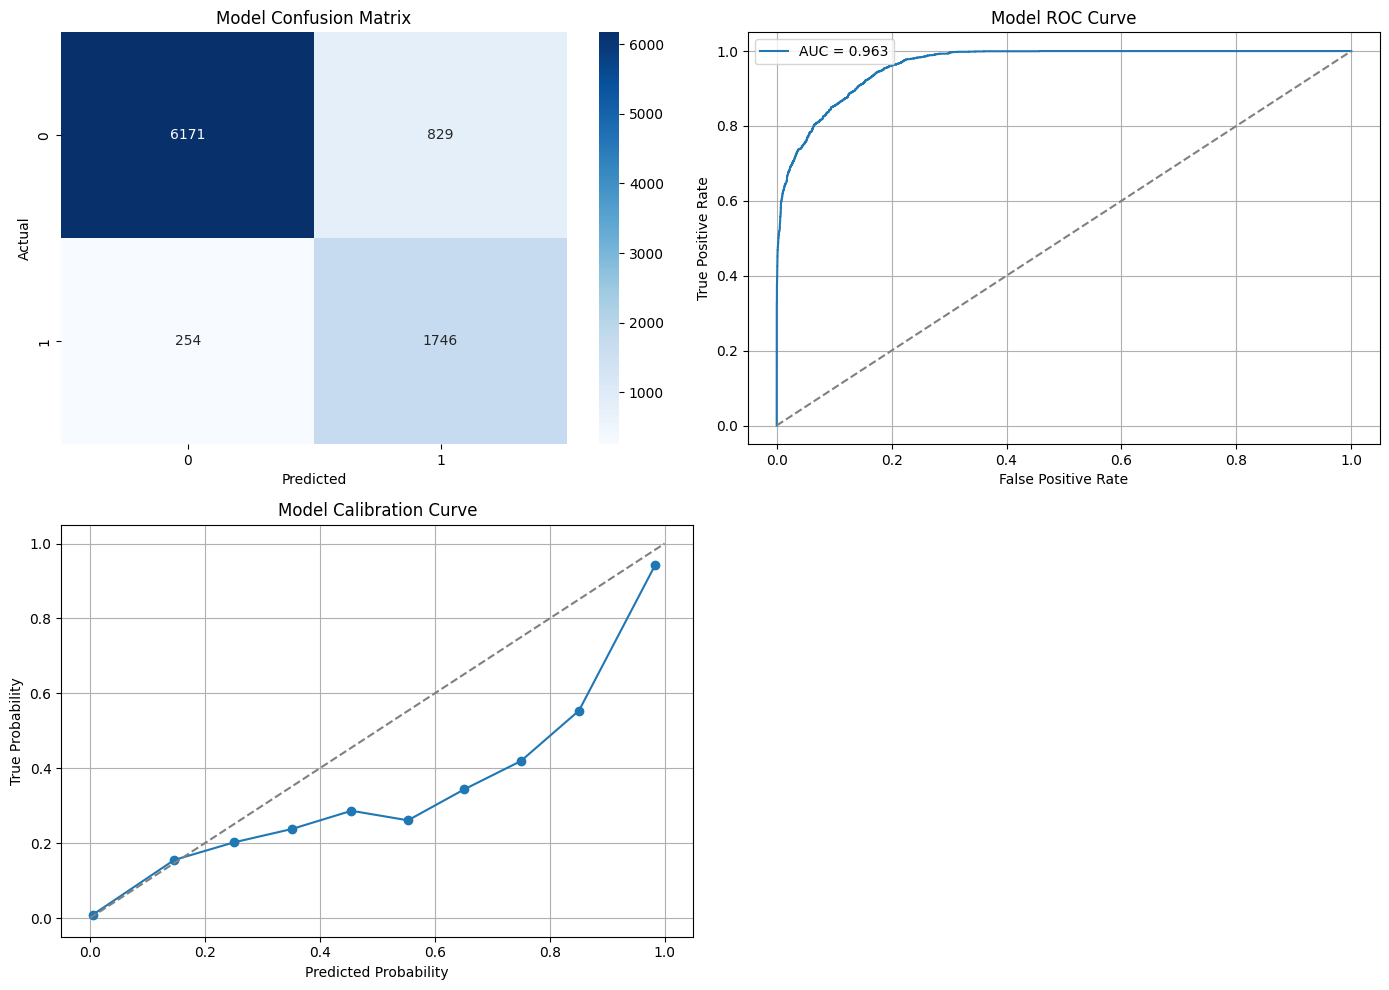

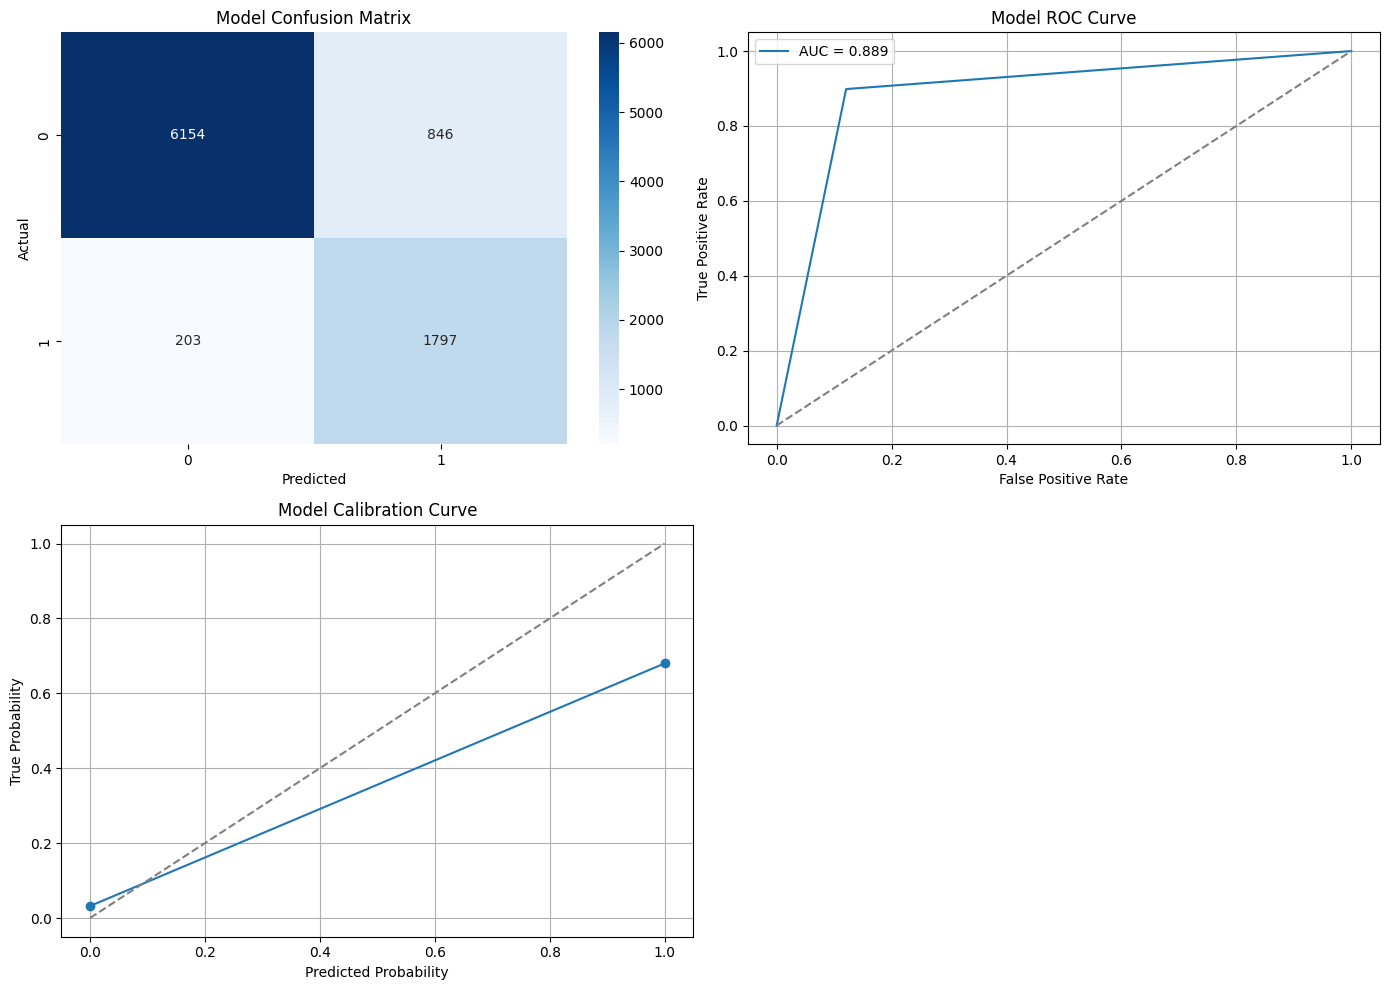

In [ ]:
plot_model_evaluation(model1)
plot_model_evaluation(best_clf)


Both models achieve high recall, meaning they correctly identify most positive cases.

The best_model shows slightly better accuracy, precision, F1-score, and specificity, indicating better overall balance between positive and negative predictions.

ROC-AUC for BatchNorm is higher than for best_model, suggesting slightly better class discrimination in BatchNorm for the test set.

# Comparing models, selecting a model, and saving the selected model and its results.



We compared the model performance in two scenarios: **without hyperparameter tuning** and **with hyperparameter tuning**, using several key metrics.

#### **Without Hyperparameter Tuning**

* **Accuracy:** 0.933
* **Precision:** 0.905
* **Recall:** 0.968
* **F1-score:** 0.935
* **Specificity:** 0.899
* **ROC-AUC:** 0.985



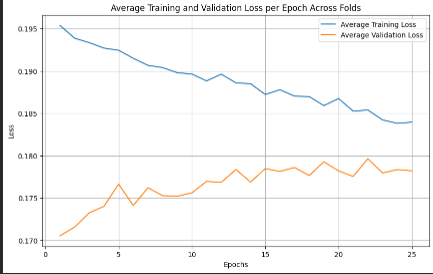

In this scenario, the model demonstrated strong performance, especially in terms of **Recall** and **ROC-AUC**, indicating good capability in identifying positive cases and distinguishing between classes.  Although the model showed good performance, it did not generalize as well, and the validation loss exhibited less stability, indicating potential overfitting or less effective generalization.
--------------------
#### **With Hyperparameter Tuning**

* **Accuracy:** 0.903
* **Precision:** 0.881
* **Recall:** 0.931
* **F1-score:** 0.905
* **Specificity:** 0.875
* **ROC-AUC:** 0.972



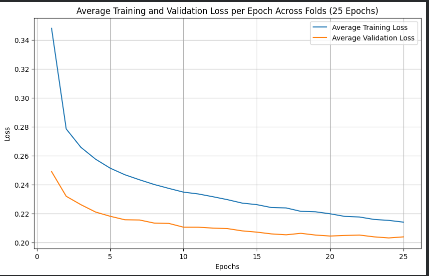



When hyperparameter tuning was applied, the overall performance slightly decreased in some metrics.

### **Conclusion**

In conclusion, despite the slightly better individual metrics of the model without hyperparameter tuning, the model with hyperparameter tuning ultimately provided better generalization and more stable performance. Therefore, the tuned model is the preferred choice for a more reliable and balanced outcome.

In [ ]:
import joblib

# Save the chosen model
joblib.dump(best_clf, "best_loan_stutes_model_DEEP_LEARNING_final.pkl")
validation_results_df.to_csv("validation_metrics.csv", index=False)
print("Model saved successfully!")

Model saved successfully!
